In [1]:
import mne
import numpy as np
import os
import fnmatch
import pandas as pd
import sklearn
import sigproc
import decoding
import openpyxl
from matplotlib import pyplot as plt

In [2]:
def plotting_function(input_data): 

    """ plot data in channel x time format """

    plt.matshow(input_data)    

Analysis Settings

In [3]:
data_filepath = r"c:\\sync_folder\\TSRlearn\\Data\\"
os.chdir(data_filepath)
subject_name = "pilot_sianna"

data_path = os.path.join(data_filepath + subject_name)

tint_epoching = (-0.1, 0.5) # time_interval for segmenting data around image presentation 


Load raw data

In [4]:
all_files = os.listdir(data_path)

fif_files = fnmatch.filter(all_files, '*tsss*.fif')
data_raw = mne.io.read_raw_fif((data_path + '//' + fif_files[1]), verbose=False)
data_raw

C:\Users\sianna.groesser\AppData\Local\Temp\ipykernel_26512\3699263332.py:4: RuntimeWarning: This filename (c:\\sync_folder\\TSRlearn\\Data\\pilot_sianna//pilot1_sianna_localiser_initial_tsss.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  data_raw = mne.io.read_raw_fif((data_path + '//' + fif_files[1]), verbose=False)
C:\Users\sianna.groesser\AppData\Local\Temp\ipykernel_26512\3699263332.py:4: RuntimeWarning: Unknown processing history item 220
  data_raw = mne.io.read_raw_fif((data_path + '//' + fif_files[1]), verbose=False)
C:\Users\sianna.groesser\AppData\Local\Temp\ipykernel_26512\3699263332.py:4: RuntimeWarning: Unknown processing history item 220
  data_raw = mne.io.read_raw_fif((data_path + '//' + fif_files[1]), verbose=False)


<Raw | pilot1_sianna_localiser_initial_tsss.fif, 319 x 2912000 (2912.0 s), ~466 KiB, data not loaded>

Plot raw data

Using matplotlib as 2D backend.


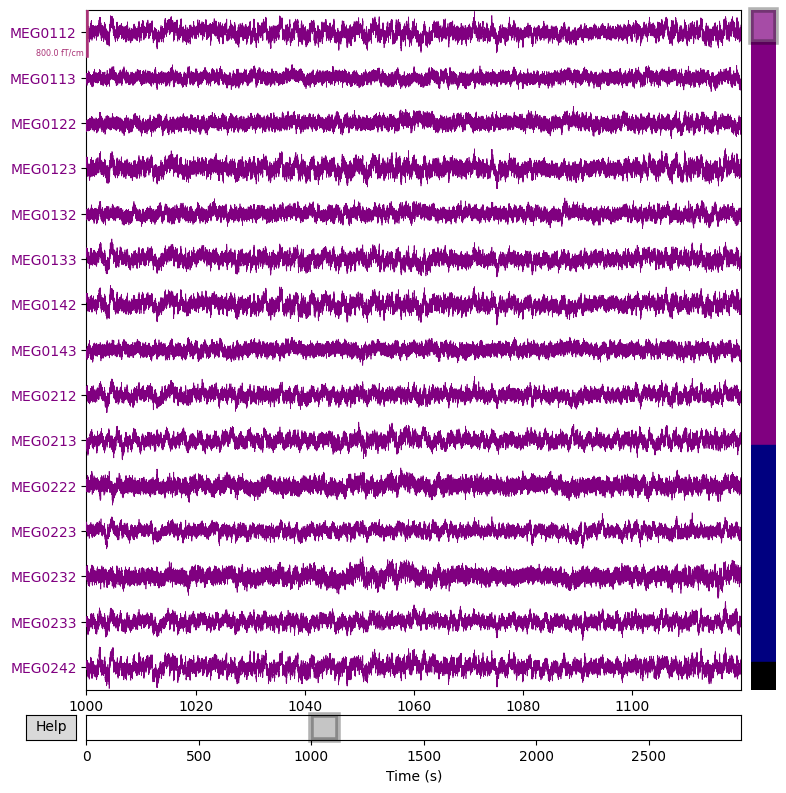

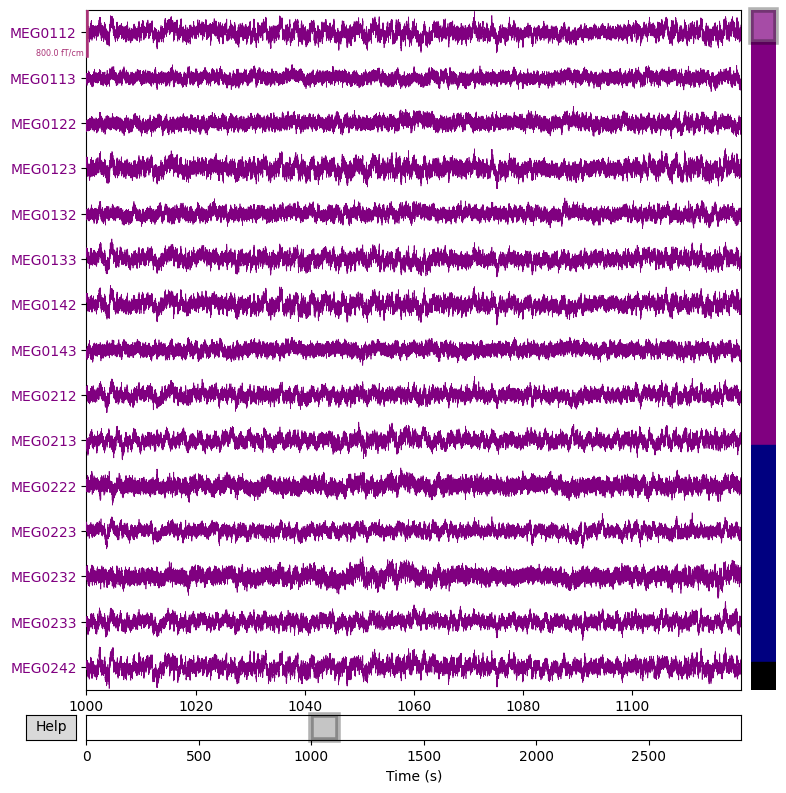

In [5]:
data_raw.plot(
   n_channels=15,          
        duration=120.0,  
        start=1000,        
        scalings= dict(mag=4e-12, grad=40e-12, eeg=150e-6),
        color=dict(mag='navy', grad='purple')
)

Find triggers in the dataset and map them to event names 

In [ ]:
# events
events = mne.find_events(data_raw, 
                'STI101', min_duration=0.005)

# create df with information 
df_events = pd.DataFrame(events, columns=['sample', 'prev_value', 'event_id'])
print(df_events)
# Convert samples to time (in hours)
sfreq = data_raw.info['sfreq']
df_events['time_sec'] = (df_events['sample'] / sfreq) 

# Optional: Map trigger codes to meaningful names
event_dict = {
    255: 'Start / End Experiment',
    99: 'Word Presented',
    127: 'Response',
    97: 'Match Prompt Response',
    96: 'Feedback',
    95: 'too slow - message',
    94: 'Fixation Cross'
}

# Add triggers 1–21 all mapped to "Image Presentation"
event_dict.update(dict.fromkeys(range(1, 22), "Image Presented"))

df_events['event_name'] = df_events['event_id'].map(event_dict).fillna('Unknown')

# Reorder columns for clarity
df_events = df_events[['time_sec', 'sample', 'event_id', 'event_name']]

# --- Display the first few rows ---
print(df_events.head(10))

# --- Save full table ---
df_events.to_excel("pilot1_all-triggers-read.xlsx", index=False)

Finding events on: STI101
4208 events found on stim channel STI101
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  80  92  94  95  96  99 112 126 127 255]
       sample  prev_value  event_id
0      173974           0        11
1      174990           0        99
2      175991           0       127
3      176007           0        96
4      176207           0        94
...       ...         ...       ...
4203  3004147           0        99
4204  3004680           0       127
4205  3004697           0        96
4206  3004897           0        94
4207  3016338           0       255

[4208 rows x 3 columns]
   time_sec  sample  event_id       event_name
0   173.974  173974        11  Image Presented
1   174.990  174990        99   Word Presented
2   175.991  175991       127         Response
3   176.007  176007        96         Feedback
4   176.207  176207        94   Fixation Cross
5   177.441  177441         8  Image Presented
6   178.4

Resample 

In [7]:
# resample 
# data = data_raw.load_data(dtype = 'float32')
# data_resampled = sigproc.resample(data_raw, 1000,100)
data_raw.resample(100)

Finding events on: STI101
4208 events found on stim channel STI101
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  80  92  94  95  96  99 112 126 127 255]
Finding events on: STI101
3407 events found on stim channel STI101
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  80  92  94  95  96  99 112 126 127 255]


<Raw | pilot1_sianna_localiser_initial_tsss.fif, 319 x 291200 (2912.0 s), ~709.2 MiB, data loaded>

Plot resampled data

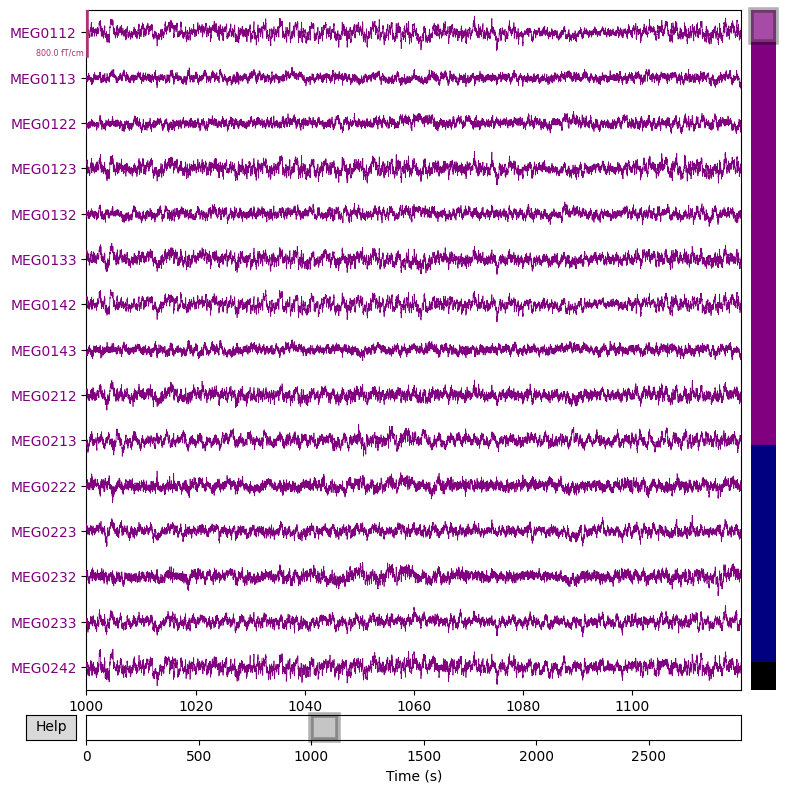

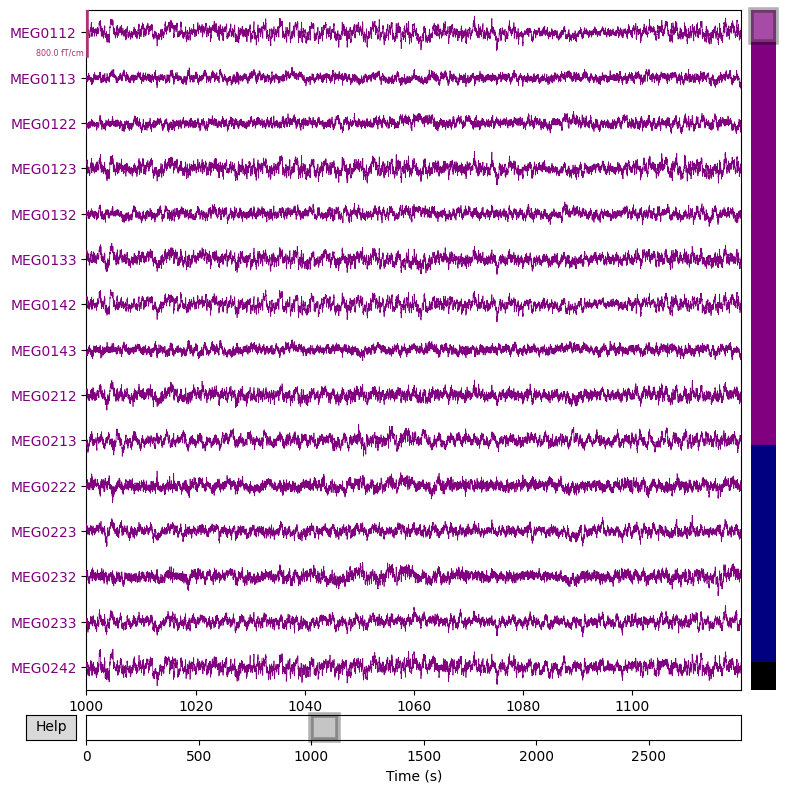

In [8]:
# plot for sanity check
data_raw.plot(n_channels=15,          
        duration=120.0,  
        start=1000,        
        scalings= dict(mag=4e-12, grad=40e-12, eeg=150e-6),
        color=dict(mag='navy', grad='purple'))

Bandpass Filter

In [9]:
# BP filter (0.5 - 40 Hz)
data_raw.filter(l_freq=0.5, h_freq=40) 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 661 samples (6.610 s)



<Raw | pilot1_sianna_localiser_initial_tsss.fif, 319 x 291200 (2912.0 s), ~709.2 MiB, data loaded>

Segment around times of image presentation

Plot filtered data

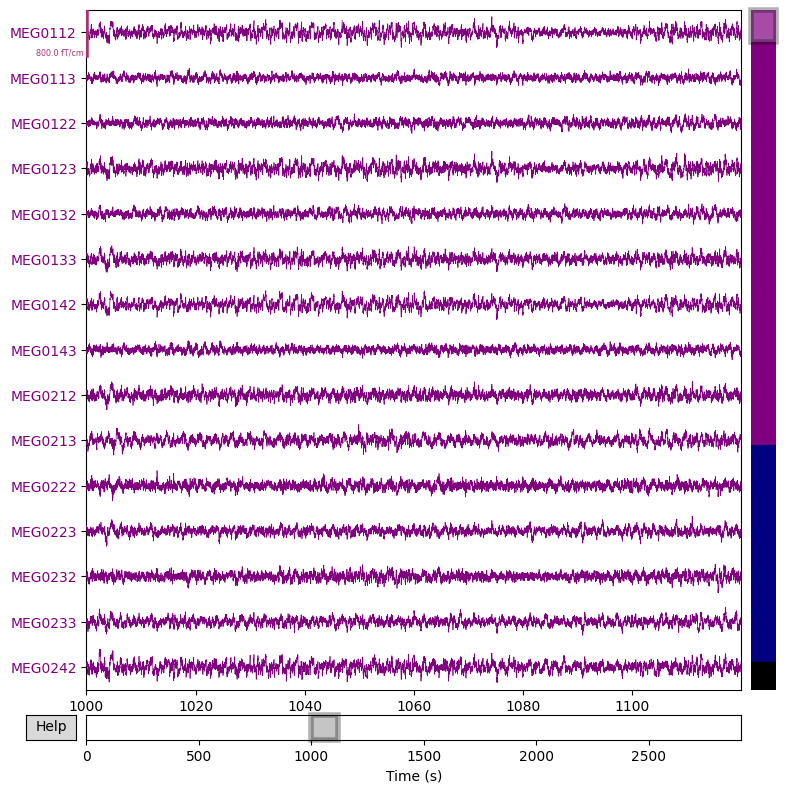

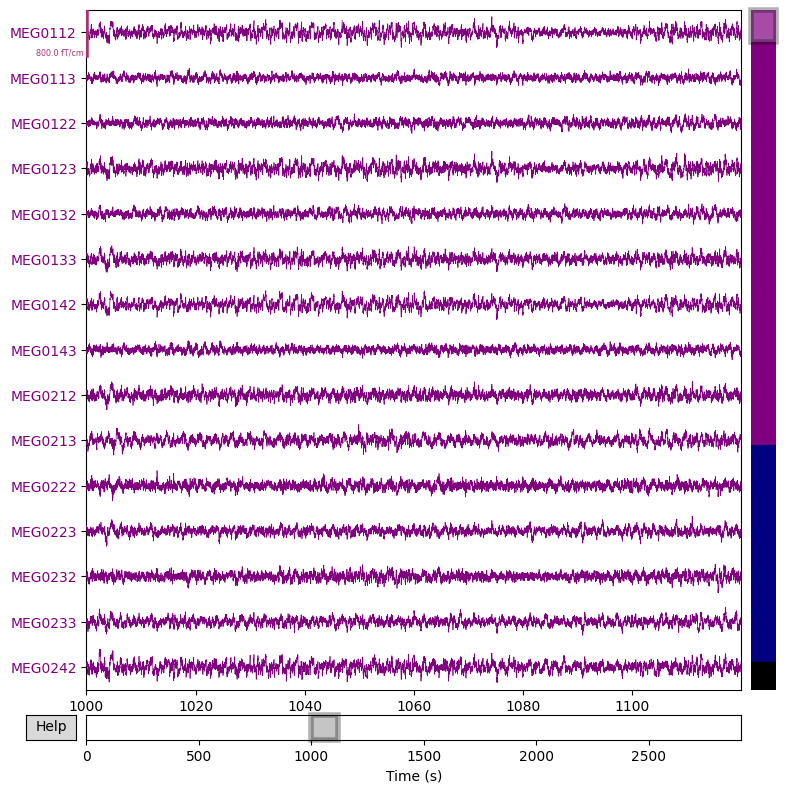

In [10]:
# plot for sanity check
data_raw.plot(n_channels=15,          
        duration=120.0,  
        start=1000,        
        scalings= dict(mag=4e-12, grad=40e-12, eeg=150e-6),
        color=dict(mag='navy', grad='purple'))

Segment data

In [46]:
# filter only event trigger where images where presented

events = mne.find_events(data_raw, stim_channel='STI101', shortest_event=1)
events_img_pres = events[np.isin(events[:, 2], np.arange(1, 22))]


print("number of img presentation events: ", len(events_img_pres))
print(events_img_pres)

Finding events on: STI101
3407 events found on stim channel STI101
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  80  92  94  95  96  99 112 126 127 255]
number of img presentation events:  841
[[ 17397      0     11]
 [ 17744      0      8]
 [ 18082      0     11]
 ...
 [299746      0     11]
 [300014      0     14]
 [300314      0      2]]


In [50]:

# option 1: numpy
unique, counts = np.unique(events_img_pres[:,2], return_counts=True)
for u, c in zip(unique, counts):
    print(f"Event code {u}: {c} times")

# (optional) restrict to certain IDs, e.g. 1..21
sel = np.isin(events_img_pres[:, 2], np.arange(1, 22))
ev = events_img_pres[sel]

sfreq = data_raw.info['sfreq']

# duration (sec) until next event; last gets inf so it won't be the minimum
dur_sec = np.diff(ev[:, 0], append=np.inf) / sfreq

# print all durations
for i, d in enumerate(dur_sec):
    print(f"Event #{i}: code={ev[i, 2]} duration≈{d:.4f}s")

# index of the shortest (ignore the last inf automatically)
idx_short = int(np.argmin(dur_sec[:-1]))

print(f"\nShortest event: index={idx_short}, code={ev[idx_short, 2]}, dur≈{dur_sec[idx_short]:.4f}s")

# exclude the shortest from your events array
ev_wo_short = np.delete(ev, idx_short, axis=0)

Event code 1: 40 times
Event code 2: 40 times
Event code 3: 40 times
Event code 4: 40 times
Event code 5: 40 times
Event code 6: 40 times
Event code 7: 40 times
Event code 8: 40 times
Event code 9: 40 times
Event code 10: 40 times
Event code 11: 40 times
Event code 12: 40 times
Event code 13: 40 times
Event code 14: 40 times
Event code 15: 40 times
Event code 16: 41 times
Event code 17: 40 times
Event code 18: 40 times
Event code 19: 40 times
Event code 20: 40 times
Event code 21: 40 times
Event #0: code=11 duration≈3.4700s
Event #1: code=8 duration≈3.3800s
Event #2: code=11 duration≈3.3700s
Event #3: code=16 duration≈3.5200s
Event #4: code=20 duration≈3.8700s
Event #5: code=10 duration≈3.3300s
Event #6: code=4 duration≈3.5900s
Event #7: code=20 duration≈3.4500s
Event #8: code=6 duration≈3.5200s
Event #9: code=8 duration≈3.0300s
Event #10: code=12 duration≈3.8000s
Event #11: code=7 duration≈3.4700s
Event #12: code=2 duration≈4.0600s
Event #13: code=15 duration≈4.1500s
Event #14: code=1

In [52]:
# segment around times of imahge presentation 
data_epoched_img = mne.Epochs(data_raw, ev_wo_short, tmin=tint_epoching[0], tmax=tint_epoching[1],preload=True, baseline=None)


Not setting metadata
840 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 840 events and 61 original time points ...
0 bad epochs dropped


Save preprocessed data

In [53]:
# safe as .fif. file to use later
# data_preprocessed = data_raw 
data_epoched_img.save(os.path.join(data_filepath , subject_name, "pilot1_Sianna_epoched_raw.fif"), overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


C:\Users\sianna.groesser\AppData\Local\Temp\ipykernel_26512\4227592554.py:3: RuntimeWarning: This filename (c:\\sync_folder\\TSRlearn\\Data\\pilot_sianna\pilot1_Sianna_epoched_raw.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  data_epoched_img.save(os.path.join(data_filepath , subject_name, "pilot1_Sianna_epoched_raw.fif"), overwrite=True)


[WindowsPath('c:/sync_folder/TSRlearn/Data/pilot_sianna/pilot1_Sianna_epoched_raw.fif')]